# Parameters Explained


This notebook explains the parameters chosen for both the undersampling and the hyperparameters of the RandomForest Classifier.

In [1]:
#import the necessary libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics
import statistics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import csv
data = pd.read_csv('healthcare-dataset-stroke-data.csv') #importing the data

In [2]:
#######Encoding and cleaning#######

#making a copy to avoid damaging original data file
data_replaced = data.copy()
data_replaced = data_replaced.drop(columns ='id')
    
#calculates the means to replace NaN
mean_values = {
    'age': data_replaced['age'].mean(),
    'avg_glucose_level': data_replaced['avg_glucose_level'].mean(),
    'bmi': data_replaced['bmi'].mean(),
}

#creating the new corrected database as a copy
data_replaced_mean = data_replaced.copy().fillna(value = mean_values) 

#Encoding the data with Onehotencoder: gender, work_type, Residence_type and smoking_status

data_onehotencoded = data_replaced_mean.copy()

def onehotencode(label, data):
    """takes column name and data as inputs returns the one hot encoded data"""
    hotencode = set(data_onehotencoded[label])
    for cls in hotencode:
        column = cls #finds each individual value in the column
        data[column] = data[label].apply(lambda x: 1 if x == cls else 0) #creates new columns
    del data[label]#eliminates original columns
    return data

#executes one hot encoding over the non numerical attributes

for i in ['gender','work_type','Residence_type','smoking_status']:
    data_onehotencoded = onehotencode(i,data_onehotencoded)

#replaces values in ever married by 1 (Yes) and 0 (No)
ever_married = set(data_onehotencoded['ever_married'])
data_onehotencoded['ever_married'] = data_onehotencoded['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)

#deleting columns that are not relevant to the problem. 
for i in ['Rural', 'Urban', 'Other','Male','Female','Unknown']:
    del data_onehotencoded[i]

#######Scaling#######

data_robust = data_onehotencoded.copy()

def robust(label: str, data):
    """Standardises the data using robust scaler"""
    rob = set(data_robust[label])
    q1_value = np.quantile(data_robust[label], 0.25) #calculates first quartile
    q3_value = np.quantile(data_robust[label], 0.75) #calculates third quartile
    diff = q3_value - q1_value #substracts the two quartiles
    #assigns the robust standardised values to the columns
    data_robust[label] = data_robust[label].apply(lambda x: (x - q1_value) / diff)
    return data_robust

#executes feature scaling over the non binary numerical data 

for i in ['age','bmi','avg_glucose_level']:
    data_robust = robust(i,data_robust)

#the non stroke proportion in this dataset is non representative of the UK population where 1/6 of the inhabitants suffer...
#...a stroke in their lifetime. 
#See https://www.gov.uk/government/news/new-figures-show-larger-proportion-of-strokes-in-the-middle-aged
#To compensate the effect of the data bias, 92% of the stroke data is removed (non stoke individuals). This...
#...corresponds to a random undersampling approach. This was chosen over over-sampling as it required less data processing...
#...and improved computational efficiency. 
data_final = data_robust.drop(data_robust[data_robust['stroke'] == 0].sample(frac=0.92).index)

data_final

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,Never_worked,children,Private,Self-employed,Govt_job,smokes,formerly smoked,never smoked
0,1.166667,0,1,1,4.110327,1.422222,1,0,0,1,0,0,0,1,0
1,1.000000,0,0,1,3.391641,0.565915,1,0,0,0,1,0,0,0,1
2,1.527778,0,1,1,0.778260,0.966667,1,0,0,1,0,0,0,0,1
3,0.666667,0,0,1,2.550821,1.177778,1,0,0,1,0,0,1,0,0
4,1.500000,1,0,1,2.629258,0.022222,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5075,1.250000,0,0,1,0.685439,1.555556,0,0,0,1,0,0,0,0,0
5078,-0.472222,0,0,0,-0.025377,-0.922222,0,0,1,0,0,0,0,0,0
5091,0.944444,1,0,1,0.483241,0.788889,0,0,0,1,0,0,0,0,1
5093,0.555556,1,0,1,0.482426,0.565915,0,0,0,0,0,1,1,0,0


In [3]:
#data splitting (see previous notebook for explanations)
X_columns = list(data_final.columns)
training_fraction: float = 0.8
y_column: str = 'stroke'
X_columns.remove(y_column)
n_rows = int(training_fraction * len(data_final))

X = data_final[X_columns].to_numpy()
y = data_final[y_column].to_numpy()
         

# get X_train and X_test
X_train = X[:n_rows]
X_test = X[n_rows:]
        
       
y_train = y[:n_rows]
y_test = y[n_rows:] 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size =0.2, random_state = 1000)

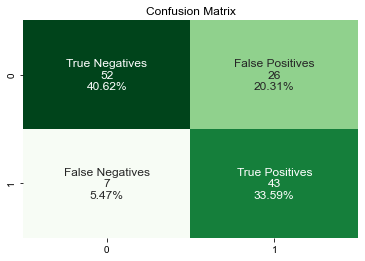

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        78
           1       0.62      0.86      0.72        50

    accuracy                           0.74       128
   macro avg       0.75      0.76      0.74       128
weighted avg       0.78      0.74      0.74       128



In [4]:

classifier = RandomForestClassifier(n_estimators= 1800, class_weight = "balanced", min_samples_split= 10, min_samples_leaf= 2,max_features= 'log2',max_depth= 90)
classifier.fit( X_train,y_train)
y_pred = classifier.predict(X_test).astype(int)
confusion_matrix=confusion_matrix(y_test,y_pred)
#fig, ax = plt.subplots()
names = ['True Negatives','False Positives','False Negatives','True Positives']
counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]
percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{n}\n{c}\n{p}" for n, c, p in
          zip(names,counts,percentages)]
labels1 = np.asarray(labels).reshape(2,2)
plt.title('Confusion Matrix')
sns.set(font_scale=1)

#annot_kws = {"ha": 'center',"va": 'center'}
sns.heatmap(confusion_matrix, annot=labels1, fmt='', cmap='Greens',cbar=False)
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))


# 1. Undersampling justification

We can see in the classification report and confusion matrix that the score for predicting if people are going to have a stroke or not is high. This is what matters the most as we are more interested in correctly predicting if a person will have a stroke rather than not have a stroke. 
Undersampling allowed to achieve higher scores overall for the stroke prediction and was decisive in choosing the parameters of the Classifier. 

Moreover, we also tested the model using oversampling.Oversampling might be better at first sight as it prevents deleting additional information provided by the dataset by simply generating new positive strokes cases instead of deleting non stroke cases. 

However, this method gives us a very low score on predictions of people who will have a stroke. Furthermore, oversampling also gives us higher number of false negatives. This is very dangerous as it predicts that people will not have a stroke when in reality they have it.

We chose undersampling because it gives us the best predictions and low false negatives all the while reducing computational effort.


In [5]:
#The randomised search function will search the parameters through 5 fold cross validation and 
#...100 iterations to end up with the best parameters.
Classifier = RandomForestClassifier().fit(X_train, y_train)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,None],

'max_features': ['auto', 'sqrt' ],

'min_samples_leaf': [1, 2, 4],

'min_samples_split': [2, 5, 10, 20, 30, 40],

'n_estimators' : [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

}
#choosing parameters to investigate 

Classifier_random= RandomizedSearchCV(estimator =  Classifier, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
Classifier_random.fit(X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.4min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [6]:
Classifier_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100}

# 2. Hypeparameters choices explained


The hyperparameters in Random Forest that we have studied in lectures are max_depth, max_features, min_samples_leaf, min_samples_split and n_estimators. 
We used RandomizedSearchCV to tune the hyperparameters and find their best values that give the highest score. In order to do so, we have to insert a range of values for each hyperparameter in the code, and it will run random combinations between them. 

For **N_estimators** we have chosen a high range: from '200' to '2000'. As n_estimators give the number of trees in the forest, higher number of trees give you better performance but makes your code slower. The higher the number of n_estimators, the better the score will be. That is why the code chose 1800 especially as the dataset is highly unbalanced. We want to maximise the number of tress in the forest to prevent inaccurate classification due to the bias of the non stroke data. 

For **max_depth**, we selected a range between '10' and '100' and 'None' ( this will go as deep as the value of min_samples_split). We want to try out large numbers because the deeper it goes, the more it captures information about our specific dataset which presents a large number of categories which will influence the final output. However, a high number of max_depth will have high variance and cause overfitting. As we have a high number of n_estimators, 90 as our max_depth value is a good estimate.

**Max_features** is usually 'auto' or 'sqrt. Sqrt turned out to be a very good value especially for Classifiers. Looking for the best split implies looking for a large number of variables to consider for an effective split as numerous parameters in the dataset will influence each other as they are corrolated (for example age and hypertension).Furthermore choosing sqrt will prevent having exactly the same tress in the entire random Forest. 

We chose a small range, from 1 to 4, for **min_samples_leaf** because high numbers can cause underfitting. The minimum number obtained (2) corresponded to the minimum number of points that need to be considered to split into a new region. This allowed to reduce the presence of a high number of outlying additional data that would result in overdividing the whole sample space due to the presence of numerous datapoints and attributes to be considered. 

Similarly, **min_samples_split** is used to control overfitting and too high values can cause underfitting. Because of this, we chose a range between 2 and 40. If the min_sample_split = 5, and there are 9 samples at the internal node than the split is allowed. If the min_samples_leaf = 4 the split will only be allowed if the split results in 4 leafs. It would not allow a split into 1 sample and 7 samples.  






